# 2.0 Imports and setup

In [ ]:
# Standard libraries
import os
from pathlib import Path
import warnings
import random
warnings.filterwarnings('ignore')

# Third-party libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Custom local imports
from model import UNet
from utils import (
    DiceBCELoss,
    train_epoch,
    validate_epoch,
    EarlyStopping
)

# Set random seeds
SEED = 1337
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# 2.1 Configuration

In [ ]:
train_file = 'train.txt'
val_file = 'val.txt'

class Config:
    # Dataset paths
    DATASET_PATH = "data\\kvasir-seg"
    IMAGE_DIR = "images"
    MASK_DIR = "masks"
    
    # Experiment parameters
    TARGET_SIZE = 256
    
    # Training parameters
    BATCH_SIZE = 8
    NUM_EPOCHS = 25
    LEARNING_RATE = 1e-4
    
    # Early stopping
    EARLY_STOPPING_PATIENCE = 5 
    # LR Scheduler
    SCHEDULER_PATIENCE = 3 
    SCHEDULER_FACTOR = 0.1 
    
    # Model parameters
    IN_CHANNELS = 3
    OUT_CHANNELS = 1
    FEATURES = [64, 128, 256, 512]
    
config = Config()

 

# 2.2 Dataset Class and Data Augmentations

In [ ]:
class KvasirDataset(Dataset):
    def __init__(self, image_paths, mask_paths, target_size=256, augmentation_type=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        
        # Base transforms (always applied)
        base_transforms = [
            A.Resize(height=target_size, width=target_size, interpolation=cv2.INTER_LINEAR),
        ]
        
        # Add augmentation based on type
        if augmentation_type == 'hflip':
            aug_transforms = [A.HorizontalFlip(p=0.5)]
        elif augmentation_type == 'vflip':
            aug_transforms = [A.VerticalFlip(p=0.5)]
        elif augmentation_type == 'rotate':
            aug_transforms = [A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, 
                                      border_mode=cv2.BORDER_REFLECT_101, p=0.7)]
        elif augmentation_type == 'colorjitter':
            aug_transforms = [A.ColorJitter(brightness=0.1, contrast=0.1, 
                                           saturation=0.1, hue=0.05, p=0.5)]
            
        else:
            aug_transforms = []
        
        # Final transforms (always applied)
        final_transforms = [
            A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
            ToTensorV2()
        ]
        
        # Combine all transforms
        self.transform = A.Compose(base_transforms + aug_transforms + final_transforms)

    def __len__(self):  
        return len(self.image_paths)
    
    def __getitem__(self, idx):  
        # Load image and mask with cv2
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        
        # Binarize mask (0 or 1)
        mask = (mask > 128).astype(np.uint8)
        
        # Apply transforms
        augmented = self.transform(image=image, mask=mask)
        
        image_tensor = augmented['image']
        mask_tensor = augmented['mask']
        
        # Add channel dimension to mask (H, W) -> (1, H, W)
        mask_tensor = mask_tensor.unsqueeze(0).float()
        
        return image_tensor, mask_tensor

# 2.3 Dataset Verification and Train/Validation Split

In [26]:
# Check files exist
if not os.path.exists('train.txt') or not os.path.exists('val.txt'):
    raise FileNotFoundError('train.txt or val.txt missing!')

# Get all image and mask paths
base_path = Path(config.DATASET_PATH)
image_paths = sorted(list((base_path / config.IMAGE_DIR).glob('*.jpg')))
mask_paths = sorted(list((base_path / config.MASK_DIR).glob('*.jpg')))

if len(image_paths) != len(mask_paths):
    raise ValueError("Mismatch between images and masks!")

print(f"Found {len(image_paths)} images")

# Read train/val split
with open('train.txt', 'r') as f:
    train_stems = {line.strip() for line in f}
with open('val.txt', 'r') as f:
    val_stems = {line.strip() for line in f}

# Split dataset
train_images = [p for p in image_paths if p.stem in train_stems]
train_masks = [p for p in mask_paths if p.stem in train_stems]
val_images = [p for p in image_paths if p.stem in val_stems]
val_masks = [p for p in mask_paths if p.stem in val_stems]

# Print split info
print(f"Training:   {len(train_images)} images ({len(train_images)/(len(train_images)+len(val_images))*100:.1f}%)")
print(f"Validation: {len(val_images)} images ({len(val_images)/(len(train_images)+len(val_images))*100:.1f}%)")



Found 1000 images
Training:   700 images (70.0%)
Validation: 300 images (30.0%)


# 2.4 Augmentation experiment loop

# 2.5 Visualization

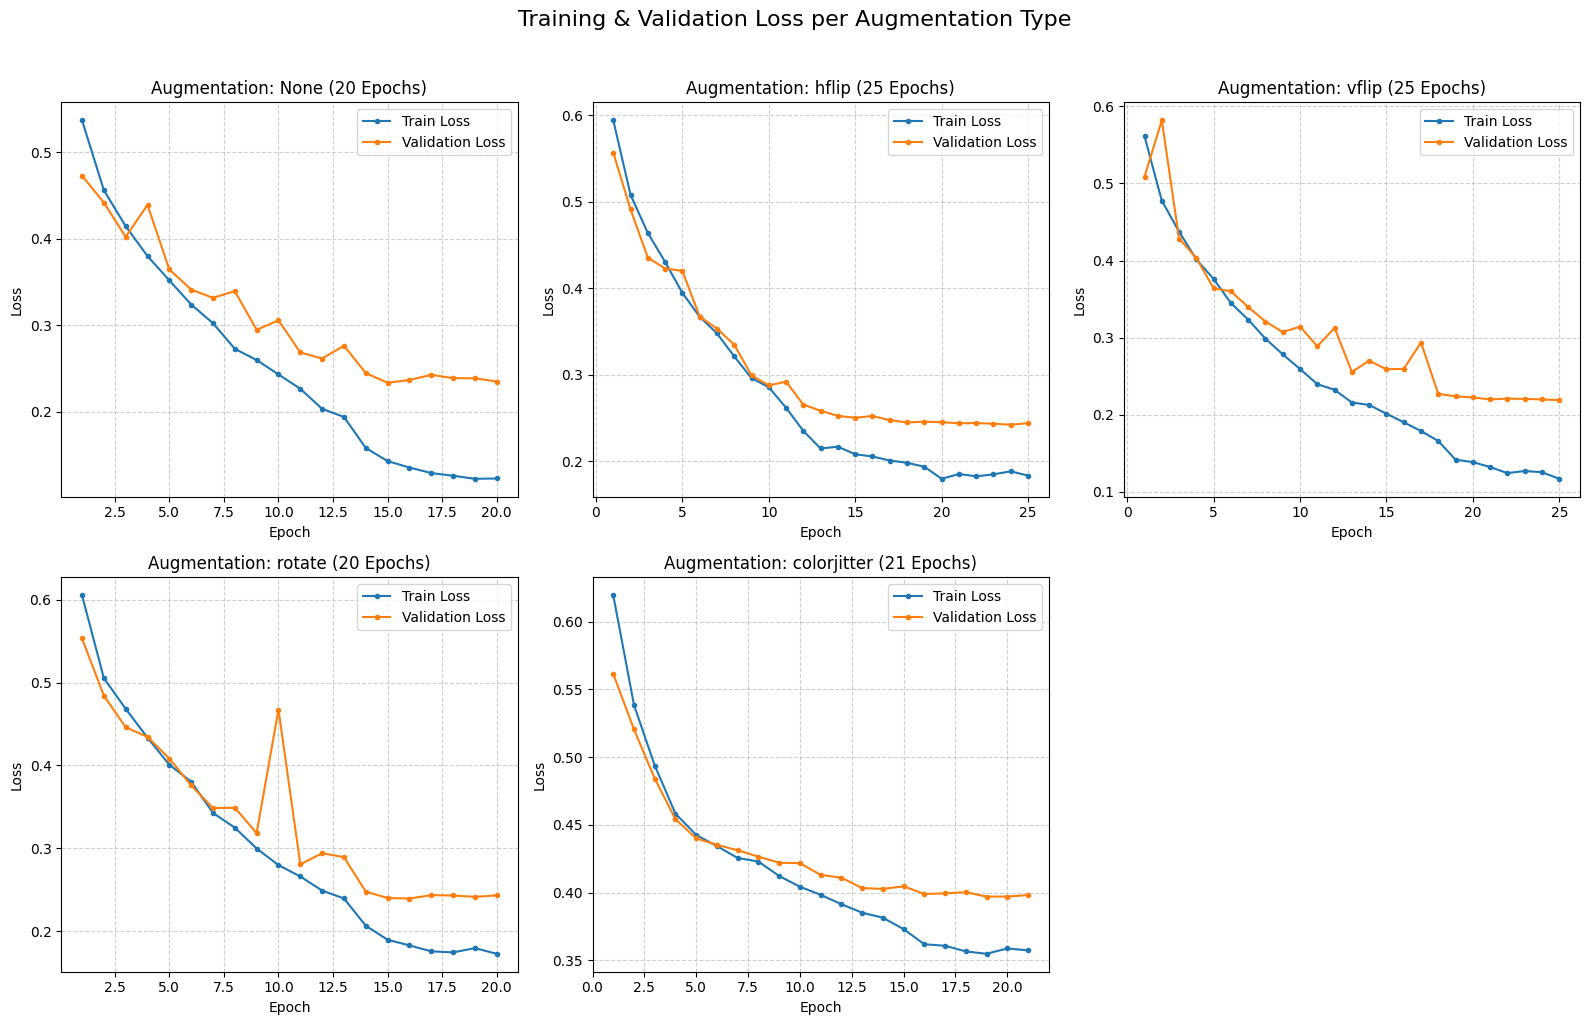

In [31]:
# Create a grid large enough for 5 plots (2x3)
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# List only the augmentations you used
augmentation_types = ['baseline', 'hflip', 'vflip', 'rotate', 'colorjitter']

# If full_history_results exists, use it
try:
    augmentation_list = list(full_history_results.keys())
except NameError:
    augmentation_list = augmentation_types

# === 2. Plot each augmentation ===
for i, aug in enumerate(augmentation_list):
    if aug in full_history_results:
        history = full_history_results[aug]
        
        epochs = len(history['train_loss'])
        epoch_range = range(1, epochs + 1)
        
        axes[i].plot(epoch_range, history['train_loss'], label='Train Loss', marker='.')
        axes[i].plot(epoch_range, history['val_loss'], label='Validation Loss', marker='.')
        axes[i].set_title(f'Augmentation: {aug} ({epochs} Epochs)')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel('Loss')
        axes[i].legend()
        axes[i].grid(True, linestyle='--', alpha=0.6)
    else:
        axes[i].set_title(f'Augmentation: {aug} (No data)')
        axes[i].axis('off')

# Turn off any unused subplot (last one if 5/6)
for j in range(len(augmentation_list), len(axes)):
    axes[j].axis('off')

fig.suptitle('Training & Validation Loss per Augmentation Type', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()



--- Final Augmentation Experiment Results ---
              val_loss      dice       iou
Augmentation                              
colorjitter   0.398909  0.696252  0.541634
hflip         0.242260  0.788677  0.659998
rotate        0.239934  0.788163  0.658760
vflip         0.219008  0.796629  0.672200
None          0.233259  0.786734  0.656403


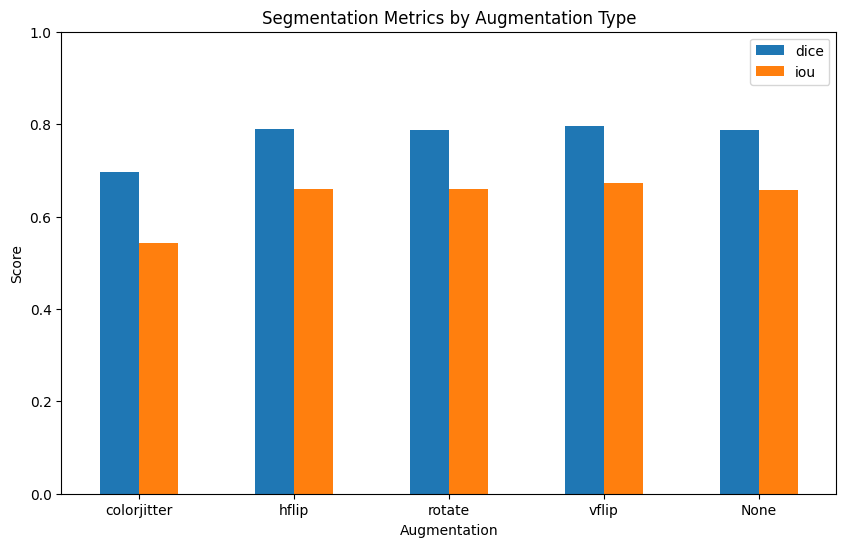

In [32]:
# Convert dictionary to DataFrame
results_df = pd.DataFrame.from_dict(experiment_results, orient='index')
results_df.index.name = 'Augmentation'
results_df = results_df.sort_index()  # sort alphabetically (optional)

print("\n--- Final Augmentation Experiment Results ---")
print(results_df)

# Optional: Plot the results
results_df.plot(kind='bar', y=['dice', 'iou'],
                title='Segmentation Metrics by Augmentation Type',
                figsize=(10, 6))
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.show()